### Final Results With Comparison to Different Model Performance

In [2]:
!pip install xgboost

In [3]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
print(pd.__version__)
import numpy as np
import json
import logging
import xgboost as xgb
import ast
import itertools
import scipy.stats as ss
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2
import os
import sys

pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)

2.2.1


In [4]:
sys.path.append('/root/Unified_LN_V2/')
from Utilities import *

In [5]:
def air_calc_new(pred,prefix):
    air = {}
    target_control_dict = [
            {'age_cuts': {
                'target': ['Age 62 and over'],
                'control': ['Age below 62']
            }},
            {'Race': {
                'target': ['black', 'hispanic'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['black'],
                'control': ['white']
            }},
            {'Race': {
                'target': ['hispanic'],
                'control': ['white']
            }},
            {'Gender': {
                'target': ['F'],
                'control': ['M']
            }},
            # 'mmct_tag': {
            #     'target': ['mmct'],
            #     'control': ['non-mmct']
            # }
    ]

    for var in target_control_dict:
        for i in var:
            target_list = var[i]['target']
            control_list = var[i]['control']
            p_target_list= ','.join(target_list) if (
                (len(target_list)<= 1) and (('black' in target_list) or ('hispanic' in target_list))
            ) else ''
            
            ttd_target= pred[pred[i].isin(target_list)]['con_wt'].sum()
            approved_target= pred[pred[i].isin(target_list)]['approved'].multiply(pred[pred[i].isin(target_list)]['con_wt']).sum()
            ttd_control= pred[pred[i].isin(control_list)]['con_wt'].sum()
            approved_control= pred[pred[i].isin(control_list)]['approved'].multiply(pred[pred[i].isin(control_list)]['con_wt']).sum()
            app_pct_target= round(approved_target/ttd_target, 4)
            app_pct_control= round(approved_control/ttd_control, 4)
            air[prefix+i+p_target_list]= [round(app_pct_target/app_pct_control, 4)]
        
            # print({'variable': i, 'target_list': p_target_list, 'ttd_target': ttd_target, 'ttd_control': ttd_control, 
                   # 'approved_target': approved_target, 'approved_control': approved_control})
            
    # print(air)
        
    return air

In [6]:
col_tuple_pass= ["unique_id", 'client', "wt2", 'fico_pb', 'auto_score', 'approve_flag', 'funded_flag', 'bad_flag', 'Race', 'Gender', 'age_cuts']

In [7]:
def get_risk_rank(data, target, cols_tuple, score_col= 'p1', weight= 'RECWGT', asc= False):
    dd = data.loc[:, cols_tuple + [score_col]]
    # dd = pd.DataFrame(dd)
    # dd = dd.reset_index()
    dd['RECWGT'] = dd["wt2"]
    dd['conwt'] = 1
    dd[target] = dd[target] 
    # pred = pd.concat([dd.loc[:, cols_tuple + ['RECWGT', 'conwt']],p],axis=1)
    pred= dd.copy()
    # display(pred.head())
    print(pred[weight].sum(),((pred[weight]*pred[target]).sum()),pred[weight].max())

    data_ks_cap5= rnkOrderingN(pred, target, weight, score_col, 5, asc)
    # display(data_ks_cap5[0])
    # print(data_ks_cap5[1])
    # data_ks_cap10= rnkOrderingN(pred, target, weight, score_col, 10, asc)
    # display(data_ks_cap10[0])
    # print(data_ks_cap10[1])
    return data_ks_cap5

In [8]:
def get_segment(d):
    if (d['derogcount']> 0):
        return 'Derog'
    elif ((d['derogcount']== 0) and (d['assetprop']> 0)):
        return 'Property Owner'
    elif ((d['derogcount']== 0) and (d['assetprop']== 0)):
        return 'Non Property Owner'
    else:
        return 'Missing'

In [9]:
def Equal_Approval_Cutoff_Barsath(pred, target, score_col, asc= True):
    pred= pred.copy()
    actual_approved_count= pred[target].sum()
    pred= pred.sort_values(by= [score_col], ascending= asc)
    pred['con_wt']= 1
    pred['cumsum']= pred['con_wt'].cumsum()
    pred['approved']= np.where(pred['cumsum']<= actual_approved_count, 1, 0)
    return pred #cutoff, original_dataset

## Reading Scored Data - Overall LDA

In [10]:
path_overall= '/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/Iteration_3/' #/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/With_LDA/
os.listdir(path_overall)

['With_LDA_Train_Auto_LN_V2_Scored_Data_2024-04-08.csv',
 '050424_LN_Auto_KGB_LDA_No_Segment_Hopt_4.csv',
 'With_LDA_Oot_Auto_LN_V2_Scored_Data_2024-04-08.csv',
 'xgbm_ln_auto_v2_hpt_best_with_lda_3.zip',
 'With_LDA_Test_Auto_LN_V2_Scored_Data_2024-04-08.csv',
 'With_LDA_TTD_Auto_LN_V2_Scored_Data_2024-04-08.csv']

In [11]:
# train_scored_all= pd.read_csv(f"{path_overall}With_LDA_Train_Auto_LN_V2_Scored_Data_2024-03-29.csv")
# test_scored_all= pd.read_csv(f"{path_overall}With_LDA_Test_Auto_LN_V2_Scored_Data_2024-03-29.csv")
# oot_scored_all= pd.read_csv(f"{path_overall}With_LDA_Oot_Auto_LN_V2_Scored_Data_2024-03-29.csv")
# ttd_scored_all= pd.read_csv(f"{path_overall}With_LDA_TTD_Auto_LN_V2_Scored_Data_2024-03-29.csv")

# train_scored_all= pd.read_csv(f"{path_overall}With_LDA_Train_Auto_LN_V2_Scored_Data_2024-04-02.csv")
# test_scored_all= pd.read_csv(f"{path_overall}With_LDA_Test_Auto_LN_V2_Scored_Data_2024-04-02.csv")
# oot_scored_all= pd.read_csv(f"{path_overall}With_LDA_Oot_Auto_LN_V2_Scored_Data_2024-04-02.csv")
# ttd_scored_all= pd.read_csv(f"{path_overall}With_LDA_TTD_Auto_LN_V2_Scored_Data_2024-04-02.csv")

train_scored_all= pd.read_csv(f"{path_overall}With_LDA_Train_Auto_LN_V2_Scored_Data_2024-04-08.csv")
test_scored_all= pd.read_csv(f"{path_overall}With_LDA_Test_Auto_LN_V2_Scored_Data_2024-04-08.csv")
oot_scored_all= pd.read_csv(f"{path_overall}With_LDA_Oot_Auto_LN_V2_Scored_Data_2024-04-08.csv")
ttd_scored_all= pd.read_csv(f"{path_overall}With_LDA_TTD_Auto_LN_V2_Scored_Data_2024-04-08.csv")

train_scored_all.shape, test_scored_all.shape, oot_scored_all.shape, ttd_scored_all.shape

((146855, 12), (62938, 12), (37121, 12), (685215, 12))

In [12]:
funded_scored_all= pd.concat([train_scored_all, test_scored_all, oot_scored_all]).reset_index(drop= True)
funded_scored_all.shape, ttd_scored_all.shape, ttd_scored_all['funded_flag'].sum()

((246914, 12), (685215, 12), 200148.0)

In [13]:
funded_scored_all['unique_id']= funded_scored_all['unique_id'].astype(str)
ttd_scored_all['unique_id']= ttd_scored_all['unique_id'].astype(str)

In [14]:
funded_scored_all.rename(columns= {'p1': 'p1_overall_lda'}, inplace= True)
ttd_scored_all.rename(columns= {'p1': 'p1_overall_lda'}, inplace= True)

### Reading V 1.5 Scored Data

In [15]:
v15= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Data/040424_Auto_LN_V1_5_Scored_Data.csv')
v15.head()

,unique_id,client,p1_v1_5,fico_pb,dataset
0,453208,SECU,0.053346,624.0,fico_lt_660
1,453394,SECU,0.064319,0.0,fico_lt_660
2,453515,SECU,0.086988,614.0,fico_lt_660
3,453555,SECU,0.035332,637.0,fico_lt_660
4,453594,SECU,0.094630,587.0,fico_lt_660


In [16]:
v15.shape, ttd_scored_all.shape, funded_scored_all.shape

((824212, 5), (685215, 12), (246914, 12))

In [17]:
v15['unique_id']= v15['unique_id'].astype(str)

In [18]:
print(ttd_scored_all.shape)
ttd_scored_all= ttd_scored_all.merge(v15[['unique_id', 'client', 'p1_v1_5']], on= ['unique_id', 'client'], how= 'left')
ttd_scored_all.shape

(685215, 12)


(685215, 13)

In [19]:
ttd_scored_all['p1_v1_5'].isnull().sum()

0

In [20]:
ttd_scored_all[['p1_v1_5', 'p1_overall_lda']].describe()

,p1_v1_5,p1_overall_lda
count,685215.000000,685215.000000
mean,0.038407,0.021863
std,0.032355,0.022076
min,0.007456,0.005289
25%,0.014268,0.007273
50%,0.025966,0.015229
75%,0.052640,0.024805
max,0.190158,0.114281


In [21]:
print(funded_scored_all.shape)
funded_scored_all= funded_scored_all.merge(v15[['unique_id', 'client', 'p1_v1_5']], on= ['unique_id', 'client'], how= 'left')
funded_scored_all.shape, funded_scored_all['p1_v1_5'].isnull().sum()

(246914, 12)


((246914, 13), 0)

In [22]:
# rnkOrderingN(funded_scored_all[~(funded_scored_all['fico_pb']>= 740)], 'bad_flag', None, 'p1_overall_lda', 5)

In [23]:
# rnkOrderingN(funded_scored_all[~(funded_scored_all['fico_pb']>= 740)], 'bad_flag', None, 'p1_v1_5', 5)

In [24]:
def get_model_comparison_segment(train_d, test_d, oot_d, ttd_d, segment, pref, d):
    train_d= train_d.copy()
    test_d= test_d.copy()
    oot_d= oot_d.copy()
    ttd_d= ttd_d.copy()
    print({'segment': segment})#, 'overall shape': data.shape, 'segmented shape': data[data['dataset'].isin(segment)].shape})
    
    a= {'Model': pref, 'Dataset': d}
    
    a[f'KS Weighted Train Model']= rnkOrderingN(train_d[train_d['dataset'].isin(segment)], 'bad_flag', 'wt2', 'p1', n_bkts= 5, asc= False)[1]['KS']
    a[f'KS Weighted Test Model']= rnkOrderingN(test_d[test_d['dataset'].isin(segment)], 'bad_flag', 'wt2', 'p1', n_bkts= 5, asc= False)[1]['KS']
    
    a[f'KS Non Weighted Train Model']= rnkOrderingN(train_d[train_d['dataset'].isin(segment)], 'bad_flag', None, 'p1', n_bkts= 5, asc= False)[1]['KS']
    a[f'KS Non Weighted Test Model']= rnkOrderingN(test_d[test_d['dataset'].isin(segment)], 'bad_flag', None, 'p1', n_bkts= 5, asc= False)[1]['KS']
    a[f'KS Non Weighted Oot Model']= rnkOrderingN(oot_d[oot_d['dataset'].isin(segment)], 'bad_flag', None, 'p1', n_bkts= 5, asc= False)[1]['KS']
    
    a[f'KS Non Weighted Oot FICO']= rnkOrderingN(test_d[test_d['dataset'].isin(segment)], 'bad_flag', None, 'fico_pb', n_bkts= 5, asc= True)[1]['KS']
    a[f'KS Non Weighted Oot Auto Score']= rnkOrderingN(test_d[test_d['dataset'].isin(segment)], 'bad_flag', None, 'auto_score', n_bkts= 5, asc= True)[1]['KS']
    
    a['Bad Rate Train']= train_d[train_d['dataset'].isin(segment)]['bad_flag'].mean()
    a['Bad Rate Test']= test_d[test_d['dataset'].isin(segment)]['bad_flag'].mean()
    a['Bad Rate Oot']= oot_d[oot_d['dataset'].isin(segment)]['bad_flag'].mean()
    
    air_sgement_model= air_calc_new(Equal_Approval_Cutoff_Barsath(ttd_d[ttd_d['dataset'].isin(segment)], 'approve_flag', 'p1'), 'AIR TTD')
    a[f'AIR Age Model']= air_sgement_model['AIR TTDage_cuts']
    a[f'AIR Race Model']= air_sgement_model['AIR TTDRace']
    a[f'AIR Race Black Model']= air_sgement_model['AIR TTDRaceblack']
    a[f'AIR Race Hispanic Model']= air_sgement_model['AIR TTDRacehispanic']
    a[f'AIR Gender Model']= air_sgement_model['AIR TTDGender']
    
    air_fico_model= air_calc_new(Equal_Approval_Cutoff_Barsath(ttd_d[ttd_d['dataset'].isin(segment)], 'approve_flag', 'fico_pb', asc= False), 'AIR TTD')
    a[f'AIR Age FICO']= air_fico_model['AIR TTDage_cuts']
    a[f'AIR Race FICO']= air_fico_model['AIR TTDRace']
    a[f'AIR Race Black FICO']= air_fico_model['AIR TTDRaceblack']
    a[f'AIR Race Hispanic FICO']= air_fico_model['AIR TTDRacehispanic']
    a[f'AIR Gender FICO']= air_fico_model['AIR TTDGender']
    
    return a

In [25]:
def get_model_comparison_overall(train_d, test_d, oot_d, ttd_d, segment, pref, d):
    train_d= train_d.copy()
    test_d= test_d.copy()
    oot_d= oot_d.copy()
    ttd_d= ttd_d.copy()
    print({'segment': segment})#, 'overall shape': data.shape, 'segmented shape': data[data['dataset'].isin(segment)].shape})
    
    a= {'Model': pref, 'Dataset': d}
    
    a[f'KS Weighted Train Model']= rnkOrderingN(train_d[train_d['dataset'].isin(segment)], 'bad_flag', 'wt2', 'p1_overall_lda', n_bkts= 5, asc= False)[1]['KS']
    a[f'KS Weighted Test Model']= rnkOrderingN(test_d[test_d['dataset'].isin(segment)], 'bad_flag', 'wt2', 'p1_overall_lda', n_bkts= 5, asc= False)[1]['KS']
    
    a[f'KS Non Weighted Train Model']= rnkOrderingN(train_d[train_d['dataset'].isin(segment)], 'bad_flag', None, 'p1_overall_lda', n_bkts= 5, asc= False)[1]['KS']
    a[f'KS Non Weighted Test Model']= rnkOrderingN(test_d[test_d['dataset'].isin(segment)], 'bad_flag', None, 'p1_overall_lda', n_bkts= 5, asc= False)[1]['KS']
    a[f'KS Non Weighted Oot Model']= rnkOrderingN(oot_d[oot_d['dataset'].isin(segment)], 'bad_flag', None, 'p1_overall_lda', n_bkts= 5, asc= False)[1]['KS']
    
    a[f'KS Non Weighted Oot FICO']= rnkOrderingN(test_d[test_d['dataset'].isin(segment)], 'bad_flag', None, 'fico_pb', n_bkts= 5, asc= True)[1]['KS']
    a[f'KS Non Weighted Oot Auto Score']= rnkOrderingN(test_d[test_d['dataset'].isin(segment)], 'bad_flag', None, 'auto_score', n_bkts= 5, asc= True)[1]['KS']
    
    a['Bad Rate Train']= train_d[train_d['dataset'].isin(segment)]['bad_flag'].mean()
    a['Bad Rate Test']= test_d[test_d['dataset'].isin(segment)]['bad_flag'].mean()
    a['Bad Rate Oot']= oot_d[oot_d['dataset'].isin(segment)]['bad_flag'].mean()
    
    air_sgement_model= air_calc_new(Equal_Approval_Cutoff_Barsath(ttd_d[ttd_d['dataset'].isin(segment)], 'approve_flag', 'p1_overall_lda'), 'AIR TTD')
    a[f'AIR Age Model']= air_sgement_model['AIR TTDage_cuts']
    a[f'AIR Race Model']= air_sgement_model['AIR TTDRace']
    a[f'AIR Race Black Model']= air_sgement_model['AIR TTDRaceblack']
    a[f'AIR Race Hispanic Model']= air_sgement_model['AIR TTDRacehispanic']
    a[f'AIR Gender Model']= air_sgement_model['AIR TTDGender']
    
    air_fico_model= air_calc_new(Equal_Approval_Cutoff_Barsath(ttd_d[ttd_d['dataset'].isin(segment)], 'approve_flag', 'fico_pb', asc= False), 'AIR TTD')
    a[f'AIR Age FICO']= air_fico_model['AIR TTDage_cuts']
    a[f'AIR Race FICO']= air_fico_model['AIR TTDRace']
    a[f'AIR Race Black FICO']= air_fico_model['AIR TTDRaceblack']
    a[f'AIR Race Hispanic FICO']= air_fico_model['AIR TTDRacehispanic']
    a[f'AIR Gender FICO']= air_fico_model['AIR TTDGender']
    
    return a
    

In [26]:
def get_model_comparison_v15(train_d, test_d, oot_d, ttd_d, segment, pref, d):
    train_d= train_d.copy()
    test_d= test_d.copy()
    oot_d= oot_d.copy()
    ttd_d= ttd_d.copy()
    print({'segment': segment})#, 'overall shape': data.shape, 'segmented shape': data[data['dataset'].isin(segment)].shape})
    
    a= {'Model': pref, 'Dataset': d}
    
    a[f'KS Weighted Train Model']= rnkOrderingN(train_d[train_d['dataset'].isin(segment)], 'bad_flag', 'wt2', 'p1_v1_5', n_bkts= 5, asc= False)[1]['KS']
    a[f'KS Weighted Test Model']= rnkOrderingN(test_d[test_d['dataset'].isin(segment)], 'bad_flag', 'wt2', 'p1_v1_5', n_bkts= 5, asc= False)[1]['KS']
    
    a[f'KS Non Weighted Train Model']= rnkOrderingN(train_d[train_d['dataset'].isin(segment)], 'bad_flag', None, 'p1_v1_5', n_bkts= 5, asc= False)[1]['KS']
    a[f'KS Non Weighted Test Model']= rnkOrderingN(test_d[test_d['dataset'].isin(segment)], 'bad_flag', None, 'p1_v1_5', n_bkts= 5, asc= False)[1]['KS']
    a[f'KS Non Weighted Oot Model']= rnkOrderingN(oot_d[oot_d['dataset'].isin(segment)], 'bad_flag', None, 'p1_v1_5', n_bkts= 5, asc= False)[1]['KS']
    
    a[f'KS Non Weighted Oot FICO']= rnkOrderingN(test_d[test_d['dataset'].isin(segment)], 'bad_flag', None, 'fico_pb', n_bkts= 5, asc= True)[1]['KS']
    a[f'KS Non Weighted Oot Auto Score']= rnkOrderingN(test_d[test_d['dataset'].isin(segment)], 'bad_flag', None, 'auto_score', n_bkts= 5, asc= True)[1]['KS']
    
    a['Bad Rate Train']= train_d[train_d['dataset'].isin(segment)]['bad_flag'].mean()
    a['Bad Rate Test']= test_d[test_d['dataset'].isin(segment)]['bad_flag'].mean()
    a['Bad Rate Oot']= oot_d[oot_d['dataset'].isin(segment)]['bad_flag'].mean()
    
    air_sgement_model= air_calc_new(Equal_Approval_Cutoff_Barsath(ttd_d[ttd_d['dataset'].isin(segment)], 'approve_flag', 'p1_v1_5'), 'AIR TTD')
    a[f'AIR Age Model']= air_sgement_model['AIR TTDage_cuts']
    a[f'AIR Race Model']= air_sgement_model['AIR TTDRace']
    a[f'AIR Race Black Model']= air_sgement_model['AIR TTDRaceblack']
    a[f'AIR Race Hispanic Model']= air_sgement_model['AIR TTDRacehispanic']
    a[f'AIR Gender Model']= air_sgement_model['AIR TTDGender']
    
    air_fico_model= air_calc_new(Equal_Approval_Cutoff_Barsath(ttd_d[ttd_d['dataset'].isin(segment)], 'approve_flag', 'fico_pb', asc= False), 'AIR TTD')
    a[f'AIR Age FICO']= air_fico_model['AIR TTDage_cuts']
    a[f'AIR Race FICO']= air_fico_model['AIR TTDRace']
    a[f'AIR Race Black FICO']= air_fico_model['AIR TTDRaceblack']
    a[f'AIR Race Hispanic FICO']= air_fico_model['AIR TTDRacehispanic']
    a[f'AIR Gender FICO']= air_fico_model['AIR TTDGender']
    
    return a

In [27]:
train_scored_all['dataset']= 'all'
test_scored_all['dataset']= 'all'
oot_scored_all['dataset']= 'all'
ttd_scored_all['dataset']= 'all'

In [28]:
print(train_scored_all.shape)
train_scored_all= train_scored_all.merge(funded_scored_all[['unique_id', 'client', 'p1_overall_lda', 'p1_v1_5']], on= ['unique_id', 'client'], how= 'left')
print(train_scored_all.shape)
print(train_scored_all[['p1', 'p1_overall_lda', 'p1_v1_5']].isnull().sum())

print(test_scored_all.shape)
test_scored_all= test_scored_all.merge(funded_scored_all[['unique_id', 'client', 'p1_overall_lda', 'p1_v1_5']], on= ['unique_id', 'client'], how= 'left')
print(test_scored_all.shape)
print(test_scored_all[['p1', 'p1_overall_lda', 'p1_v1_5']].isnull().sum())

print(oot_scored_all.shape)
oot_scored_all= oot_scored_all.merge(funded_scored_all[['unique_id', 'client', 'p1_overall_lda', 'p1_v1_5']], on= ['unique_id', 'client'], how= 'left')
print(oot_scored_all.shape)
print(oot_scored_all[['p1', 'p1_overall_lda', 'p1_v1_5']].isnull().sum())

(146855, 13)
(146855, 15)
p1                0
p1_overall_lda    0
p1_v1_5           0
dtype: int64
(62938, 13)
(62938, 15)
p1                0
p1_overall_lda    0
p1_v1_5           0
dtype: int64
(37121, 13)
(37121, 15)
p1                0
p1_overall_lda    0
p1_v1_5           0
dtype: int64


In [29]:
pd.concat(
    [
     pd.DataFrame(get_model_comparison_overall(train_scored_all, test_scored_all, oot_scored_all, ttd_scored_all, ['all'], 'Overall', 'all')),
     pd.DataFrame(get_model_comparison_v15(train_scored_all, test_scored_all, oot_scored_all, ttd_scored_all, ['all'], 'V1.5', 'all'))]
)

{'segment': ['all']}
{'segment': ['all']}


,Model,Dataset,KS Weighted Train Model,KS Weighted Test Model,KS Non Weighted Train Model,KS Non Weighted Test Model,KS Non Weighted Oot Model,KS Non Weighted Oot FICO,KS Non Weighted Oot Auto Score,Bad Rate Train,Bad Rate Test,Bad Rate Oot,AIR Age Model,AIR Race Model,AIR Race Black Model,AIR Race Hispanic Model,AIR Gender Model,AIR Age FICO,AIR Race FICO,AIR Race Black FICO,AIR Race Hispanic FICO,AIR Gender FICO
0,Overall,all,37.42,39.07,38.63,38.06,38.74,44.62,39.01,0.015165,0.015237,0.014682,1.4450,0.7644,0.7497,0.7804,0.9215,1.286,0.7384,0.6168,0.8728,0.9247
0,V1.5,all,44.74,44.22,45.67,45.13,44.14,44.62,39.01,0.015165,0.015237,0.014682,1.4141,0.7115,0.6549,0.7740,0.9355,1.286,0.7384,0.6168,0.8728,0.9247


### AIR Continum

In [30]:
ttd_scored_all.describe()

,wt2,fico_pb,auto_score,approve_flag,funded_flag,bad_flag,p1_overall_lda,p1_v1_5
count,685215.0,678989.000000,685215.000000,685215.000000,401605.000000,200148.000000,685215.000000,685215.000000
mean,1.0,663.072047,716.564983,0.586101,0.498370,0.015224,0.021863,0.038407
std,0.0,165.346145,45.649687,0.492531,0.499998,0.122442,0.022076,0.032355
min,1.0,0.000000,548.000000,0.000000,0.000000,0.000000,0.005289,0.007456
25%,1.0,627.000000,686.000000,0.000000,0.000000,0.000000,0.007273,0.014268
50%,1.0,688.000000,715.000000,1.000000,0.000000,0.000000,0.015229,0.025966
75%,1.0,752.000000,748.000000,1.000000,1.000000,0.000000,0.024805,0.052640
max,1.0,9999.000000,827.000000,1.000000,1.000000,1.000000,0.114281,0.190158


In [31]:
## Creating 20-Decile
def get_data_cuts(data, q, score, asc= True):
    data= data.copy()
    data= data.sort_values(by= [score], ascending= asc).reset_index(drop= True)
    data['counter']= 1
    data['cumsum']= data['counter'].cumsum()
    
    bins= [-np.inf] + [int(round((len(data)/q)*i)) for i in range(1, q)] + [np.inf]
    labels= [i for i in range(1, q+1)]
    print(bins)
    print(labels)
    
    data['decile']= pd.cut(x= data['cumsum'], bins= bins, labels= labels)
    
    return data

In [32]:
# ttd_scored_all_lda= get_data_cuts(ttd_scored_all, q= 20, score= 'p1_overall_lda')
# ttd_scored_all.shape, ttd_scored_all_lda.shape

In [33]:
# %%time
# air_cont_lda= []

# for d in sorted(list(ttd_scored_all_lda['decile'].unique())):
#     a= {}
#     temp= ttd_scored_all_lda[ttd_scored_all_lda['decile']== d]
#     print(d, temp.shape)
#     a['decile']= d
#     a['apps']= len(temp)
#     a['min_pd']= temp['p1_overall_lda'].min()
#     a['mean_pd']= temp['p1_overall_lda'].mean()
#     a['max_pd']= temp['p1_overall_lda'].max()
    
#     air_temp= air_calc_new(Equal_Approval_Cutoff_Barsath(temp, 'approve_flag', 'p1_overall_lda'), 'AIR TTD')
#     # print(air_temp)
#     a[f'AIR Age']= air_temp['AIR TTDage_cuts'][0]
#     a[f'AIR Race']= air_temp['AIR TTDRace'][0]
#     a[f'AIR Race Black']= air_temp['AIR TTDRaceblack'][0]
#     a[f'AIR Race Hispanic']= air_temp['AIR TTDRacehispanic'][0]
#     a[f'AIR Gender']= air_temp['AIR TTDGender'][0]
    
#     air_cont_lda.append(a)
#     print(a)
#     del a

In [34]:
# air_cont_lda= pd.DataFrame(air_cont_lda)
# air_cont_lda

In [35]:
# ttd_scored_all_v15= get_data_cuts(ttd_scored_all, q= 20, score= 'p1_v1_5')
# print(ttd_scored_all.shape, ttd_scored_all_v15.shape)

# air_cont_v15= []

# for d in sorted(list(ttd_scored_all_v15['decile'].unique())):
#     a= {}
#     temp= ttd_scored_all_v15[ttd_scored_all_v15['decile']== d]
#     print(d, temp.shape)
#     a['decile']= d
#     a['apps']= len(temp)
#     a['min_pd']= temp['p1_v1_5'].min()
#     a['mean_pd']= temp['p1_v1_5'].mean()
#     a['max_pd']= temp['p1_v1_5'].max()
    
#     air_temp= air_calc_new(Equal_Approval_Cutoff_Barsath(temp, 'approve_flag', 'p1_v1_5'), 'AIR TTD')
#     # print(air_temp)
#     a[f'AIR Age']= air_temp['AIR TTDage_cuts'][0]
#     a[f'AIR Race']= air_temp['AIR TTDRace'][0]
#     a[f'AIR Race Black']= air_temp['AIR TTDRaceblack'][0]
#     a[f'AIR Race Hispanic']= air_temp['AIR TTDRacehispanic'][0]
#     a[f'AIR Gender']= air_temp['AIR TTDGender'][0]
    
#     air_cont_v15.append(a)
#     print(a)
#     del a, temp

In [36]:
# air_cont_v15= pd.DataFrame(air_cont_v15)
# air_cont_v15

### Ashwin Approach

In [37]:
def percentage_approval_cutoff(pred, score_col, percentage, asc= True):
    pred= pred.copy()
    approved_count= int(len(pred)*percentage)
    pred= pred.sort_values(by= [score_col], ascending= asc)
    pred['con_wt']= 1
    pred['cumsum']= pred['con_wt'].cumsum()
    pred['approved']= np.where(pred['cumsum']<= approved_count, 1, 0)
    return pred #cutoff, original_dataset

In [38]:
def get_cutoffs_air(data, score, n_bkts= 20, asc= True):
    data= data.copy()
    # asc= asc.copy()
    
    air_details= []
    for i in [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90]:
        perc= i #i*0.05
        a= {}
        a['cutoff']= perc
        temp= percentage_approval_cutoff(data, score, perc, asc= asc)
        a['min_pd']= temp[temp['approved']== 1][score].min()
        a['max_pd']= temp[temp['approved']== 1][score].max()
        a['ttd']= len(temp)
        a['approved_client']= temp['approve_flag'].sum()
        a['approved_scienaptic']= temp['approved'].sum()
        temp_air= air_calc_new(temp, 'AIR TTD')
        a[f'AIR Age']= temp_air['AIR TTDage_cuts'][0]
        a[f'AIR Race']= temp_air['AIR TTDRace'][0]
        a[f'AIR Race Black']= temp_air['AIR TTDRaceblack'][0]
        a[f'AIR Race Hispanic']= temp_air['AIR TTDRacehispanic'][0]
        a[f'AIR Gender']= temp_air['AIR TTDGender'][0]

        air_details.append(a)
        # print(a)
        del a, temp, temp_air
        
    return pd.DataFrame(air_details)

In [39]:
ttd_scored_all['approve_flag'].mean()

0.5861007129149245

In [40]:
[0.5861007129149245] + list(range(4, 16))

[0.5861007129149245, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [41]:
air_cont_lda_ashwin= get_cutoffs_air(ttd_scored_all, 'p1_overall_lda')
air_cont_lda_ashwin

,cutoff,min_pd,max_pd,ttd,approved_client,approved_scienaptic,AIR Age,AIR Race,AIR Race Black,AIR Race Hispanic,AIR Gender
0,0.10,0.005289,0.005875,685215,401605.0,68521,1.5913,0.4966,0.5794,0.4046,0.8231
1,0.15,0.005289,0.006468,685215,401605.0,102782,1.7104,0.5720,0.6334,0.5043,0.8225
2,0.20,0.005289,0.006586,685215,401605.0,137043,1.8580,0.6315,0.6963,0.5597,0.8361
3,0.25,0.005289,0.007273,685215,401605.0,171303,1.8425,0.6224,0.6843,0.5538,0.8393
4,0.30,0.005289,0.008012,685215,401605.0,205564,1.8447,0.6317,0.6906,0.5667,0.8493
5,0.35,0.005289,0.008979,685215,401605.0,239825,1.8279,0.6428,0.6839,0.5971,0.8505
6,0.40,0.005289,0.010209,685215,401605.0,274086,1.7429,0.6478,0.6715,0.6219,0.8529
7,0.45,0.005289,0.013283,685215,401605.0,308346,1.6349,0.6516,0.6646,0.6374,0.8693
8,0.50,0.005289,0.015229,685215,401605.0,342607,1.5429,0.6914,0.6897,0.6933,0.8893
9,0.55,0.005289,0.016803,685215,401605.0,376868,1.4688,0.7347,0.7324,0.7372,0.9136


In [43]:
air_cont_lda_ashwin= []
for i in [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.5861007129149245, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85]:
    perc= i #i*0.05
    a= {}
    a['cutoff']= perc
    temp= percentage_approval_cutoff(ttd_scored_all, 'p1_overall_lda', perc)
    a['min_pd']= temp[temp['approved']== 1]['p1_overall_lda'].min()
    a['max_pd']= temp[temp['approved']== 1]['p1_overall_lda'].max()
    a['ttd']= len(temp)
    a['approved_client']= temp['approve_flag'].sum()
    a['approved_scienaptic']= temp['approved'].sum()
    temp_air= air_calc_new(temp, 'AIR TTD')
    a[f'AIR Age']= temp_air['AIR TTDage_cuts'][0]
    a[f'AIR Race']= temp_air['AIR TTDRace'][0]
    a[f'AIR Race Black']= temp_air['AIR TTDRaceblack'][0]
    a[f'AIR Race Hispanic']= temp_air['AIR TTDRacehispanic'][0]
    a[f'AIR Gender']= temp_air['AIR TTDGender'][0]
    
    air_cont_lda_ashwin.append(a)
    print(a)
    del a, temp, temp_air

{'cutoff': 0.2, 'min_pd': 0.0052891406230628, 'max_pd': 0.0065857898443937, 'ttd': 685215, 'approved_client': 401605.0, 'approved_scienaptic': 137043, 'AIR Age': 1.858, 'AIR Race': 0.6315, 'AIR Race Black': 0.6963, 'AIR Race Hispanic': 0.5597, 'AIR Gender': 0.8361}
{'cutoff': 0.25, 'min_pd': 0.0052891406230628, 'max_pd': 0.0072728926315903, 'ttd': 685215, 'approved_client': 401605.0, 'approved_scienaptic': 171303, 'AIR Age': 1.8425, 'AIR Race': 0.6224, 'AIR Race Black': 0.6843, 'AIR Race Hispanic': 0.5538, 'AIR Gender': 0.8393}
{'cutoff': 0.3, 'min_pd': 0.0052891406230628, 'max_pd': 0.0080122668296098, 'ttd': 685215, 'approved_client': 401605.0, 'approved_scienaptic': 205564, 'AIR Age': 1.8447, 'AIR Race': 0.6317, 'AIR Race Black': 0.6906, 'AIR Race Hispanic': 0.5667, 'AIR Gender': 0.8493}
{'cutoff': 0.35, 'min_pd': 0.0052891406230628, 'max_pd': 0.0089786034077405, 'ttd': 685215, 'approved_client': 401605.0, 'approved_scienaptic': 239825, 'AIR Age': 1.8279, 'AIR Race': 0.6428, 'AIR Rac

In [44]:
ttd_scored_all[['p1_overall_lda', 'p1_v1_5']].describe()

,p1_overall_lda,p1_v1_5
count,685215.000000,685215.000000
mean,0.021863,0.038407
std,0.022076,0.032355
min,0.005289,0.007456
25%,0.007273,0.014268
50%,0.015229,0.025966
75%,0.024805,0.052640
max,0.114281,0.190158


In [45]:
air_cont_lda_ashwin= pd.DataFrame(air_cont_lda_ashwin)
air_cont_lda_ashwin

,cutoff,min_pd,max_pd,ttd,approved_client,approved_scienaptic,AIR Age,AIR Race,AIR Race Black,AIR Race Hispanic,AIR Gender
0,0.200000,0.005289,0.006586,685215,401605.0,137043,1.8580,0.6315,0.6963,0.5597,0.8361
1,0.250000,0.005289,0.007273,685215,401605.0,171303,1.8425,0.6224,0.6843,0.5538,0.8393
2,0.300000,0.005289,0.008012,685215,401605.0,205564,1.8447,0.6317,0.6906,0.5667,0.8493
3,0.350000,0.005289,0.008979,685215,401605.0,239825,1.8279,0.6428,0.6839,0.5971,0.8505
4,0.400000,0.005289,0.010209,685215,401605.0,274086,1.7429,0.6478,0.6715,0.6219,0.8529
5,0.450000,0.005289,0.013283,685215,401605.0,308346,1.6349,0.6516,0.6646,0.6374,0.8693
6,0.500000,0.005289,0.015229,685215,401605.0,342607,1.5429,0.6914,0.6897,0.6933,0.8893
7,0.550000,0.005289,0.016803,685215,401605.0,376868,1.4688,0.7347,0.7324,0.7372,0.9136
8,0.586101,0.005289,0.018113,685215,401605.0,401605,1.4450,0.7644,0.7497,0.7804,0.9215
9,0.600000,0.005289,0.018214,685215,401605.0,411129,1.4238,0.7728,0.7629,0.7836,0.9289


In [50]:
air_cont_v15_ashwin= []
for i in [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.5861007129149245, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85]:
    perc= i #i*0.05
    a= {}
    a['cutoff']= perc
    temp= percentage_approval_cutoff(ttd_scored_all, 'p1_v1_5', perc)
    a['min_pd']= temp[temp['approved']== 1]['p1_v1_5'].min()
    a['max_pd']= temp[temp['approved']== 1]['p1_v1_5'].max()
    a['ttd']= len(temp)
    a['approved_client']= temp['approve_flag'].sum()
    a['approved_scienaptic']= temp['approved'].sum()
    temp_air= air_calc_new(temp, 'AIR TTD')
    a[f'AIR Age']= temp_air['AIR TTDage_cuts'][0]
    a[f'AIR Race']= temp_air['AIR TTDRace'][0]
    a[f'AIR Race Black']= temp_air['AIR TTDRaceblack'][0]
    a[f'AIR Race Hispanic']= temp_air['AIR TTDRacehispanic'][0]
    a[f'AIR Gender']= temp_air['AIR TTDGender'][0]
    
    air_cont_v15_ashwin.append(a)
    del a, temp_air

In [51]:
air_cont_v15_ashwin= pd.DataFrame(air_cont_v15_ashwin)
air_cont_v15_ashwin

,cutoff,min_pd,max_pd,ttd,approved_client,approved_scienaptic,AIR Age,AIR Race,AIR Race Black,AIR Race Hispanic,AIR Gender
0,0.200000,0.007456,0.013025,685215,401605.0,137043,1.6096,0.4638,0.4981,0.4257,0.8418
1,0.250000,0.007456,0.014268,685215,401605.0,171303,1.6072,0.4964,0.5161,0.4751,0.8533
2,0.300000,0.007456,0.015816,685215,401605.0,205564,1.6373,0.5276,0.5339,0.5202,0.8629
3,0.350000,0.007456,0.017901,685215,401605.0,239825,1.6328,0.5497,0.5465,0.5534,0.8714
4,0.400000,0.007456,0.020287,685215,401605.0,274086,1.5932,0.5732,0.5624,0.5852,0.8850
5,0.450000,0.007456,0.022776,685215,401605.0,308346,1.5381,0.6101,0.5891,0.6332,0.9013
6,0.500000,0.007456,0.025966,685215,401605.0,342607,1.4902,0.6424,0.6131,0.6746,0.9168
7,0.550000,0.007456,0.029316,685215,401605.0,376868,1.4479,0.6844,0.6420,0.7314,0.9295
8,0.586101,0.007456,0.032332,685215,401605.0,401605,1.4141,0.7115,0.6549,0.7740,0.9355
9,0.600000,0.007456,0.033842,685215,401605.0,411129,1.3975,0.7167,0.6580,0.7817,0.9385


In [52]:
temp.shape

(685215, 17)

In [53]:
temp[['approve_flag', 'approved']].sum()

approve_flag    401605.0
approved        582432.0
dtype: float64

In [54]:
temp.groupby('Gender').agg(
    ttd= ('unique_id', 'count'),
    approved= ('approved', 'sum')
)

,ttd,approved
Gender,,
F,260261,219820
I,51041,39738
M,373913,322874


In [55]:
rnkOrderingN(train_scored_all, 'bad_flag', 'wt2', 'p1_v1_5', 5)

(   min_score  max_score  mean_score         total         Goods         Bads  \
 0   0.050637   0.188945    0.079493  49036.601375  45764.793618  3271.807758   
 1   0.026892   0.050637    0.036356  49033.880827  47919.076067  1114.804760   
 2   0.017259   0.026892    0.021436  49033.372583  48537.475651   495.896932   
 3   0.012215   0.017259    0.014430  49034.536000  48778.201661   256.334340   
 4   0.007456   0.012215    0.010070  49034.263867  48937.865601    96.398266   
 
    Bad_Rate  Cum_Total  Cum_Good  Cum_Bad     KS  
 0      6.67       20.0     19.07    62.50  43.43  
 1      2.27       40.0     39.05    83.79  44.74  
 2      1.01       60.0     59.27    93.26  33.99  
 3      0.52       80.0     79.60    98.16  18.56  
 4      0.20      100.0    100.00   100.00   0.00  ,
 {'Gini': 56.28999999999999, 'KS': 44.74})

In [56]:
rnkOrderingN(train_scored_all, 'bad_flag', None, 'p1_v1_5', 5)

(   min_score  max_score  mean_score  total    Goods    Bads  Bad_Rate  \
 0   0.037367   0.188945    0.066938  29372  27925.0  1447.0      4.93   
 1   0.021351   0.037367    0.027660  29370  28948.0   422.0      1.44   
 2   0.014759   0.021351    0.017651  29372  29179.0   193.0      0.66   
 3   0.011293   0.014759    0.012917  29371  29253.0   118.0      0.40   
 4   0.007456   0.011293    0.009593  29370  29323.0    47.0      0.16   
 
    Cum_Total  Cum_Good  Cum_Bad     KS  
 0       20.0     19.31    64.98  45.67  
 1       40.0     39.32    83.92  44.60  
 2       60.0     59.50    92.59  33.09  
 3       80.0     79.73    97.89  18.16  
 4      100.0    100.00   100.00   0.00  ,
 {'Gini': 56.61000000000001, 'KS': 45.67})

### Non-LDA TTD Scored

In [57]:
df_non_lda_ttd= pd.read_csv('/root/Unified_LN_V2/LN_Auto_V2/Model_Data/Without_LDA_Auto_LN_V2/Without_LDA/Without_LDA_TTD_Auto_LN_V2_Scored_Data_2024-04-01.csv')
df_non_lda_ttd.shape

(685215, 12)

In [58]:
df_non_lda_ttd['p1'].nunique()

571239

In [59]:
df_non_lda_ttd['3_digit_score']= df_non_lda_ttd['p1'].apply(lambda x: convert_to_3_digit(x))
df_non_lda_ttd['3_digit_score'].nunique()

309

In [60]:
df_non_lda_ttd['3_digit_score'].describe()

count    685215.000000
mean        737.619089
std          47.272061
min         544.000000
25%         704.000000
50%         739.000000
75%         774.000000
max         860.000000
Name: 3_digit_score, dtype: float64

In [61]:
air_cont_v15_ashwin= []
for i in [0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.5861007129149245, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85]:
    perc= i #i*0.05
    a= {}
    a['cutoff']= perc
    temp= percentage_approval_cutoff(df_non_lda_ttd, 'p1', perc)
    a['min_pd']= temp[temp['approved']== 1]['p1'].min()
    a['max_pd']= temp[temp['approved']== 1]['p1'].max()
    a['ttd']= len(temp)
    a['approved_client']= temp['approve_flag'].sum()
    a['approved_scienaptic']= temp['approved'].sum()
    temp_air= air_calc_new(temp, 'AIR TTD')
    a[f'AIR Age']= temp_air['AIR TTDage_cuts'][0]
    a[f'AIR Race']= temp_air['AIR TTDRace'][0]
    a[f'AIR Race Black']= temp_air['AIR TTDRaceblack'][0]
    a[f'AIR Race Hispanic']= temp_air['AIR TTDRacehispanic'][0]
    a[f'AIR Gender']= temp_air['AIR TTDGender'][0]
    
    air_cont_v15_ashwin.append(a)
    del a, temp_air

In [62]:
air_cont_v15_ashwin= pd.DataFrame(air_cont_v15_ashwin)
air_cont_v15_ashwin

,cutoff,min_pd,max_pd,ttd,approved_client,approved_scienaptic,AIR Age,AIR Race,AIR Race Black,AIR Race Hispanic,AIR Gender
0,0.200000,0.000761,0.004658,685215,401605.0,137043,1.6385,0.3882,0.4910,0.2749,0.8478
1,0.250000,0.000761,0.005487,685215,401605.0,171303,1.6612,0.4260,0.5208,0.3208,0.8609
2,0.300000,0.000761,0.006428,685215,401605.0,205564,1.6679,0.4631,0.5534,0.3630,0.8725
3,0.350000,0.000761,0.007518,685215,401605.0,239825,1.6563,0.4962,0.5755,0.4085,0.8845
4,0.400000,0.000761,0.008828,685215,401605.0,274086,1.6314,0.5287,0.5981,0.4518,0.8975
5,0.450000,0.000761,0.010400,685215,401605.0,308346,1.5980,0.5642,0.6264,0.4952,0.9119
6,0.500000,0.000761,0.012298,685215,401605.0,342607,1.5528,0.6006,0.6575,0.5378,0.9268
7,0.550000,0.000761,0.014531,685215,401605.0,376868,1.5019,0.6365,0.6880,0.5796,0.9406
8,0.586101,0.000761,0.016341,685215,401605.0,401605,1.4596,0.6601,0.7071,0.6082,0.9478
9,0.600000,0.000761,0.017092,685215,401605.0,411129,1.4431,0.6702,0.7153,0.6202,0.9518


### Plot ROC AUC Score

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import auc, roc_auc_score, roc_curve#, plot_roc_curve

### Plot ROC Curve
def plot_roc_auc(y, y_, model):
    plt.figure(figsize= (10, 4))
    lr_fpr, lr_tpr, _= roc_curve(y, y_)
    
    y__= np.zeros((len(y), 1))
    ns_fpr, ns_tpr, _= roc_curve(y, y__)
    
    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label= model)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model}, AUC Score: {round(auc(lr_fpr, lr_tpr), 4)}')
    # show the legend
#     plt.legend()
    # show the plot
    plt.show()

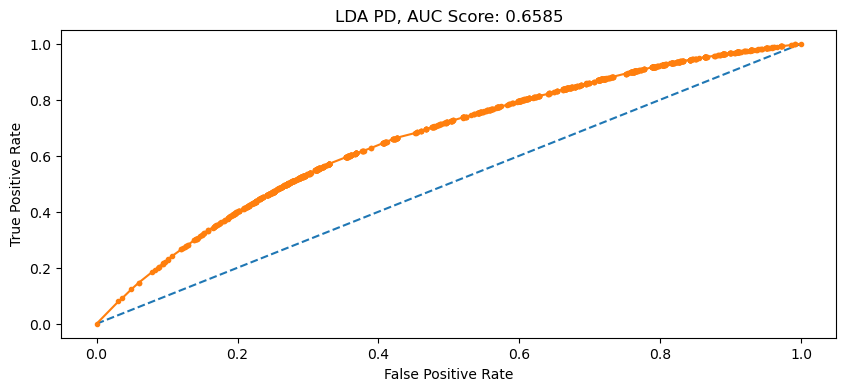

In [58]:
plot_roc_auc(
    ttd_scored_all['approve_flag'],
    1-ttd_scored_all['p1_overall_lda'],
    'LDA PD'
)

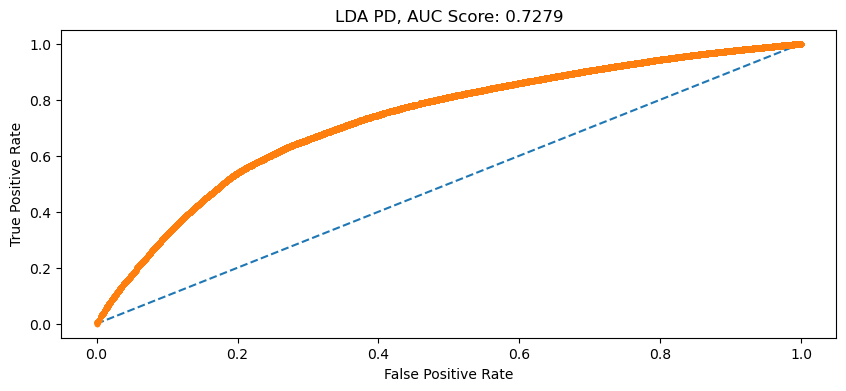

In [59]:
plot_roc_auc(
    ttd_scored_all['approve_flag'],
    1-ttd_scored_all['p1_v1_5'],
    'LDA PD'
)

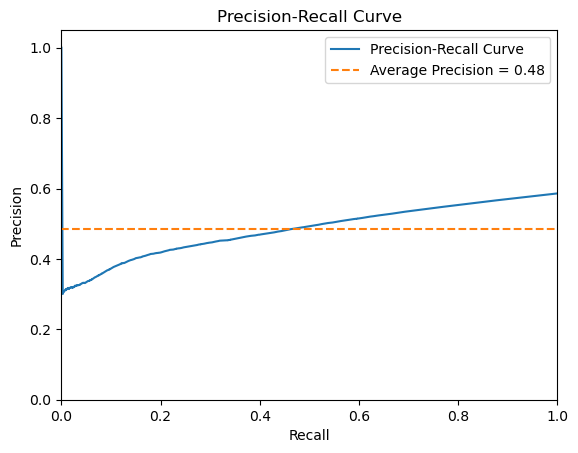

In [60]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Assuming you have your true labels (y_true) and predicted scores (y_score):
y_true = ttd_scored_all['approve_flag']
y_score = ttd_scored_all['p1_overall_lda']

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_score)

# Calculate average precision score
average_precision = average_precision_score(y_true, y_score)

# Plot the precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Plot the average precision score
plt.plot([0, 1], [average_precision, average_precision], linestyle='--', label='Average Precision = {0:0.2f}'.format(average_precision))

# Add plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

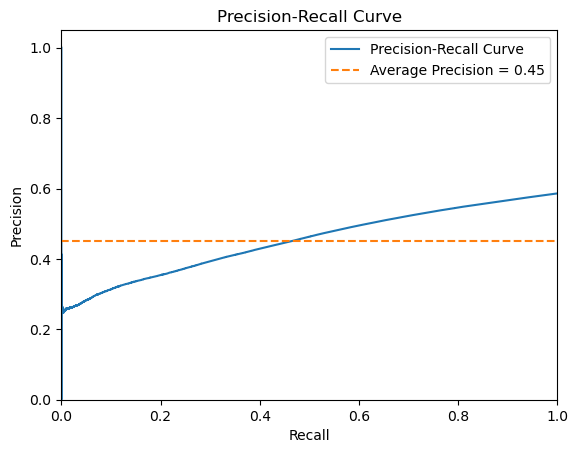

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Assuming you have your true labels (y_true) and predicted scores (y_score):
y_true = ttd_scored_all['approve_flag']
y_score = ttd_scored_all['p1_v1_5']

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_score)

# Calculate average precision score
average_precision = average_precision_score(y_true, y_score)

# Plot the precision-recall curve
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')

# Plot the average precision score
plt.plot([0, 1], [average_precision, average_precision], linestyle='--', label='Average Precision = {0:0.2f}'.format(average_precision))

# Add plot labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [63]:
ttd_scored_all_lda['cumsum_pd']= ttd_scored_all_lda['p1_overall_lda'].cumsum()
ttd_scored_all_lda[['cumsum_pd', 'cumsum']].describe()

,cumsum_pd,cumsum
count,685215.000000,685215.000000
mean,4013.725837,342608.000000
std,3645.994429,197804.676689
min,0.005289,1.000000
25%,1045.429865,171304.500000
50%,2824.731354,342608.000000
75%,6198.147887,513911.500000
max,14980.727381,685215.000000


In [65]:
ttd_scored_all_lda['cumsum_bad']= ttd_scored_all_lda['bad_flag'].cumsum()

<Axes: >

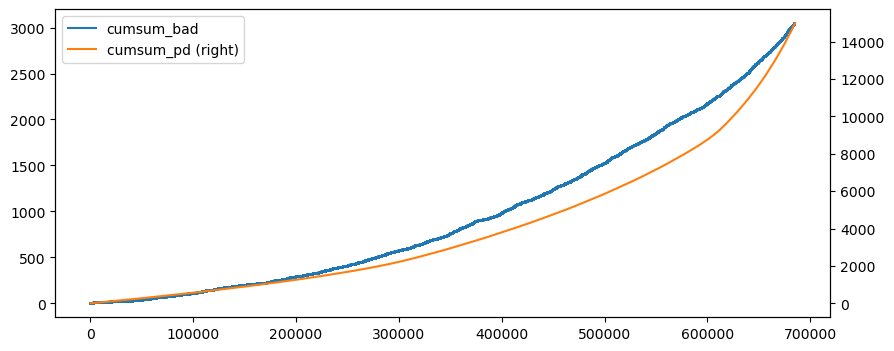

In [68]:
ttd_scored_all_lda[['cumsum_bad', 'cumsum_pd']].plot(secondary_y= 'cumsum_pd', figsize= (10, 4))